# Datathon Cajamar PythonHack 2016
Equipo: WoodenSpoonNinjas

Comenzamos importando los paquetes y módulos que vamos a utilizar

In [6]:
from collections import Counter
import numpy as np
import pandas as pd
import seaborn

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix, classification_report
from sklearn import metrics   # Más métricas

from sklearn.model_selection import GridSearchCV  # Validación cruzada en rejilla de parámetros

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
  
import itertools

Cargamos los datos de entrenamiento (previamente convertidos a csv) como un Pandas DataFrame y separamos las variables independientes `X` y la variable dependiente `y`. Al terminar, contamos el número de registros en cada clase.

In [7]:
filename = 'pm_train.csv'
D = pd.read_csv(filename)
columns = D.columns

X = D.drop(["TARGET"],axis=1).values
y = D['TARGET'].values
print(Counter(y))

Counter({0: 464360, 1: 7478})


Como se puede ver, el número de muestras en cada clase es muy dispar (sólo un 1.6% de ellas pertenecen a la clase 1).  En este punto, tenemos 2 opciones: 
1. Ajustar el número de muestras en ambas clase para que sean iguales (utilizando técnicas de undersampling, oversampling o una combinación de ellas)
2. No ajustar el número de muestras y hacer que nuestra técnica tenga en cuenta esta probabilidad en sus predicciones.

En los criterios de evaluación del reto, se indica que clasificar correctamente ambas clases será tenido en consideración (se valorará especificidad y sensibilidad). Consecuentemente, seguiremos la aproximación 1, para que nuestros resultados no estén sesgados hacia la clase 0 debido al desbalance. De esta manera, conseguimos también que los resultados sean robustos a futuros cambios en la probabilidad a priori de cliente pidiendo/no pidiendo préstamos.

In [17]:
method = "US"
if method == "US":
    from imblearn.under_sampling import RandomUnderSampler
    resamp = RandomUnderSampler(random_state=42)
    X_res, y_res = resamp.fit_sample(X, y)
elif  method == "OS":
    from imblearn.over_sampling import SMOTE
    resamp = SMOTE(random_state=42)
    X_res, y_res = resamp.fit_sample(X, y)
    sel = np.random.randint(0, y_res.shape[0], 20000)
    X_res = X_res[sel,:]
    y_res = y_res[sel]   
else:
    X_res, y_res = X, y

print(Counter(y_res))

Counter({0: 7478, 1: 7478})


In [18]:
X_sel = X_res  # Seleccionamos para el entrenamiento todas las características remuestreadas

## Validación cruzada
Como modelo de clasificación utilizaremos un *eXtreme Gradient Boosting model* de la biblioteca `xgboost`. Para realizar la selección de los hiperparámetros del modelo utilizaremos un sistema de validación cruzada secuencial ya que, por el tiempo (y potencia de cálculo) limitada de que disponemos nos imposible realizar una búsqueda exhaustiva en toda la rejilla de hiperparámetros.

### Selección del número de estimadores
En primer lugar fijamos todos los parámetros del modelo excepto el número de estimadores y realizamos una validación cruzada de este último parámetro. Para ello, primero implementamos una función auxiliar `modelfit` para realizar el barrido.

In [19]:
def modelfit(alg, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(predictors, label=target)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])

        
    # Fit the algorithm on the data
    alg.fit(predictors, target, eval_metric='auc')

    # Predict training set:
    dtrain_predictions = alg.predict(predictors)
    dtrain_predprob = alg.predict_proba(predictors)[:, 1]

    # Print model report:
    print("Model Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(target, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(target, dtrain_predprob))
    

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    plt.figure(figsize=(20,10))
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return alg

Ejecutamos el barrido y observamos que finaliza indicando que el número optimo de estimadores es 385. A partir de este punto, fijaremos este hiperparámetro para optimizar el resto 

[0]	train-auc:0.839808+0.00171059	test-auc:0.826817+0.0103184
[1]	train-auc:0.851201+0.00392178	test-auc:0.837704+0.00693683
[2]	train-auc:0.858353+0.00328648	test-auc:0.84396+0.0079885
[3]	train-auc:0.86212+0.00330253	test-auc:0.847497+0.00756405
[4]	train-auc:0.865265+0.00278012	test-auc:0.85011+0.00799946
[5]	train-auc:0.867921+0.00302978	test-auc:0.852881+0.00793075
[6]	train-auc:0.86987+0.00339854	test-auc:0.854506+0.00822721
[7]	train-auc:0.872393+0.00287162	test-auc:0.856482+0.00791109
[8]	train-auc:0.874293+0.00311432	test-auc:0.858005+0.00736747
[9]	train-auc:0.876129+0.00277235	test-auc:0.859624+0.007468
[10]	train-auc:0.877636+0.00269972	test-auc:0.860497+0.00767365
[11]	train-auc:0.879046+0.00246435	test-auc:0.861499+0.0079584
[12]	train-auc:0.880173+0.00245154	test-auc:0.862691+0.00771334
[13]	train-auc:0.881602+0.00205924	test-auc:0.86382+0.00788325
[14]	train-auc:0.882786+0.00191871	test-auc:0.864604+0.00805297
[15]	train-auc:0.884163+0.00179159	test-auc:0.865775+0.00806

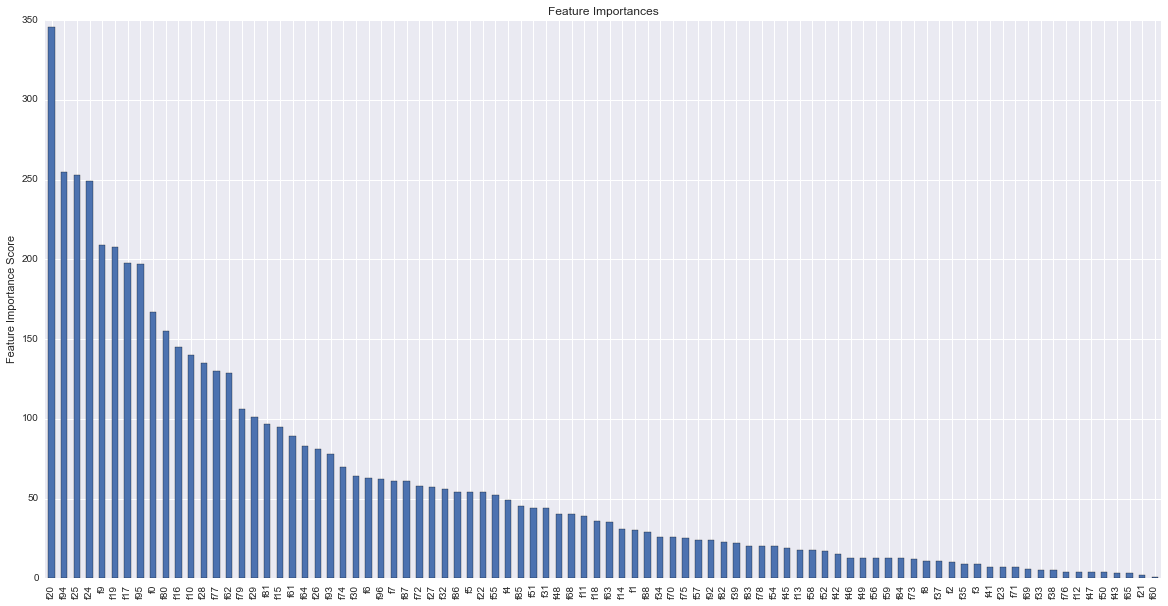

In [26]:
xgb1 = XGBClassifier(
 learning_rate=0.1,
 n_estimators= 1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=-1,
 scale_pos_weight=1,
 seed=27)
alg = modelfit(xgb1, X_sel, y_res)

In [22]:
# Guardamos el modelo entrenado
#from sklearn.externals import joblib
#joblib.dump(alg,'imbalanced_alg.pkl')
#joblib.dump(alg,'balanced_undersampled_alg.pkl')
#alg = joblib.load('imbalanced_alg.pkl')
#alg = joblib.load('balanced_undersampled_alg.pkl')

In [ ]:
### Selección del número de estimadores
param_test1 = {
 'max_depth': range(3,10,2),
 'min_child_weight': range(1,6,2)
}
gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=385, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
 param_grid = param_test1, scoring='roc_auc', n_jobs=-1, iid=False, cv=5, verbose=10)

gsearch1.fit(X_sel, y_res)

### Selección de los parámetros `max_depth` y `min_child_weight`
Esta es la selección óptima obtenida por el proceso de validación cruzada:
~~~~
gsearch1.best_params_ = 
 {'max_depth': 5, 'min_child_weight': 1}
~~~~

In [ ]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=385, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27),
 param_grid = param_test3, scoring='roc_auc', n_jobs=-1, iid=False, cv=5, verbose=10)
gsearch2.fit(X_sel, y_res)

### Selección de parámetro `gamma`
Esta es la selección óptima obtenida por el proceso de validación cruzada:
~~~~
gsearch2.best_params_ = 
 {'gamma': 0.0}
~~~~

### Selección del resto de parámetros
El resto de parámetros son seleccionados de la misma manera. Para limitar la extensión de este documento, no se muestran aquí los detalles pero sí los resultados finales.

## Modelo final
Tras las validaciones cruzadas terminamos con el modelo final indicado a continuación:

In [59]:
alg = XGBClassifier(
 learning_rate=0.1,
 n_estimators= 385,
 max_depth=5,  # máxima profundidad de los árboles base (mucha profundidad -> sobrejuste)
 min_child_weight=1,  # mínima suma de los pesos para todas las observaciones en un hijo
 gamma=0,  # mejora mínima para un nuevo split
 subsample=0.8,  # fracción de las muestras para evitar sobreajuste
 colsample_bytree=0.8, # fraccion de las columnas
 objective= 'binary:logistic', # función de clasificación para clasificación binaria
 nthread=-1,  # utilizamos todos los cores disponibles
 scale_pos_weight=1,  # 1: alto desequilibrio entre classes
 seed=27)  # definimos una semilla para que los resultados sean reproducibles

Dividimos el conjunto de datos en test y train y hacemos una última validación cruzada antes de aplicar el modelo a los datos e test. Hacemos esto para asegurarnos de que no existe sobreajuste y nuestras predicciones no están sesgadas por el desbalance entre clases.

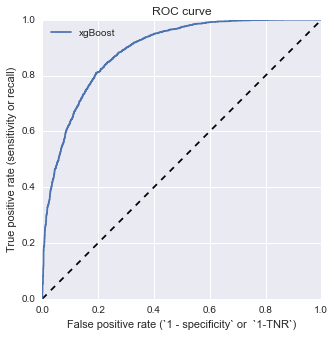

ROC-AUC = 0.8902205725912139


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_sel, y_res, test_size=0.4, random_state=0, stratify=y_res)
alg = alg.fit(X_train, y_train)
y_pred = alg.predict(X_test)
pred_prob = alg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, pred_prob)

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='xgBoost')
plt.xlabel('False positive rate (`1 - specificity` or  `1-TNR`)')
plt.ylabel('True positive rate (sensitivity or recall)')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#score = alg.score(X_test, y_test)
auc = roc_auc_score(y_test, pred_prob)
print("ROC-AUC = {}".format(auc))

In [28]:
print(confusion_matrix(y_test, y_pred))

[[2341  651]
 [ 509 2482]]


Confusion matrix, without normalization
[[2341  651]
 [ 509 2482]]
Normalized confusion matrix
[[ 0.78  0.22]
 [ 0.17  0.83]]


C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


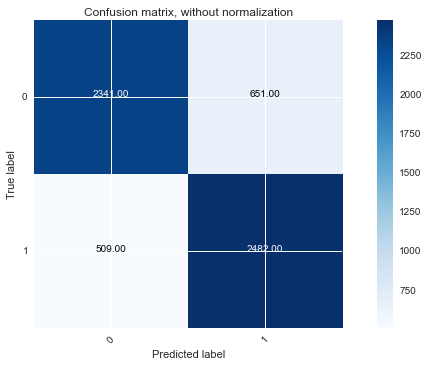

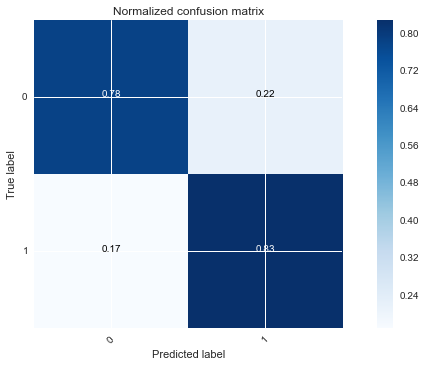

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f" % cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.colorbar()    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ["0", "1"]    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [42]:
filename = 'pm_test.txt'  # leemos el fichero con los datos de test

D = pd.read_csv(filename, delimiter="|", decimal=",", index_col = 0)

# Sort columns by name
D = D.reindex_axis(sorted(D.columns), axis=1)

In [49]:
# Predecimos sobre el conjunto de test
X_test_final = D.values
y_pred_final = alg.predict(X_test_final)
Counter(y_pred_final)  # contamos el número de muestras en cada clase

Counter({0: 154864, 1: 47653})

# Generación de fichero de respuesta

In [55]:
D_resp = pd.Series(y_pred_final, index = D.index, name="Respuesta").to_frame()

In [60]:
D_resp.to_csv("submission.txt", sep="|")